In [100]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
import cmath

In [101]:
%matplotlib inline
import matplotlib.pyplot as plt

### Импорт сырых данных из .s2p файла и перевод их в комплексные числа

In [102]:
data = pd.read_csv('with_object.s2p', sep=' ', header=None, skiprows=9, 
                names=['Frequency', 'ReS11', 'ImS11', 'ReS21', 'ImS21', 'ReS12', 'ImS12', 'ReS22', 'ImS22'])

In [103]:
data.head()

,Frequency,ReS11,ImS11,ReS21,ImS21,ReS12,ImS12,ReS22,ImS22
0,8000000000,-0.603198,0.340968,0.202231,-0.659156,0.202394,-0.659378,-0.318107,-0.610675
1,8002500000,-0.597377,0.351603,0.173953,-0.667929,0.173775,-0.666899,-0.359732,-0.588324
2,8005000000,-0.589782,0.363280,0.144315,-0.673027,0.144606,-0.674572,-0.397614,-0.563438
3,8007500000,-0.582762,0.376279,0.114245,-0.679524,0.114307,-0.679730,-0.435280,-0.535226
4,8010000000,-0.575124,0.387404,0.083724,-0.683397,0.085051,-0.683624,-0.469673,-0.505567


Перевод данных в вид комплексных чисел

In [104]:
data['s11']=data['ReS11']+1j*data['ImS11']
data['s21']=data['ReS21']+1j*data['ImS21']
data['s12']=data['ReS12']+1j*data['ImS12']
data['s22']=data['ReS22']+1j*data['ImS22']

Удаление исходных колонок

In [105]:
data = data.drop(['ReS11', 'ImS11', 'ReS21', 'ImS21', 'ReS12', 'ImS12', 'ReS22', 'ImS22'], axis=1)

In [106]:
data.head()

,Frequency,s11,s21,s12,s22
0,8000000000,-0.603198+0.340968j,0.202231-0.659156j,0.202394-0.659378j,-0.318107-0.610675j
1,8002500000,-0.597377+0.351603j,0.173953-0.667929j,0.173775-0.666899j,-0.359732-0.588324j
2,8005000000,-0.589782+0.363280j,0.144315-0.673027j,0.144606-0.674572j,-0.397614-0.563438j
3,8007500000,-0.582762+0.376279j,0.114245-0.679524j,0.114307-0.679730j,-0.435280-0.535226j
4,8010000000,-0.575124+0.387404j,0.083724-0.683397j,0.085051-0.683624j,-0.469673-0.505567j


### Предпросмотр графиков необработанных файлов

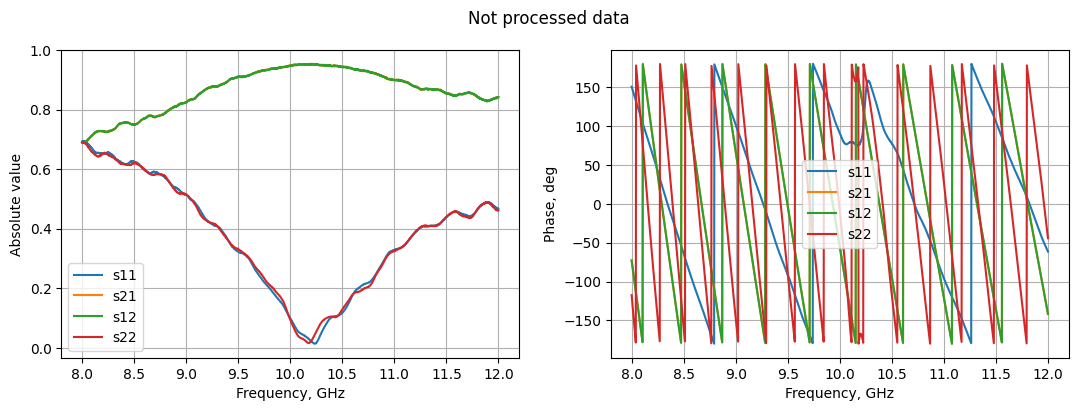

In [107]:
s_par = ['s11', 's21', 's12', 's22']

fig = plt.figure(figsize=(13,4))

ax_1 = fig.add_subplot(121)
for elem in s_par:
    ax_1.plot(data['Frequency']*1e-9, data[elem].apply(abs), label=elem)
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value")
plt.legend()
plt.grid()

ax_2 = fig.add_subplot(122)
for elem in s_par:
    ax_2.plot(data['Frequency']*1e-9, np.degrees(data[elem].apply(cmath.phase)), label=elem)
ax_2.set_xlabel("Frequency, GHz")
ax_2.set_ylabel("Phase, deg")
plt.legend()
plt.grid()

fig.suptitle('Not processed data')
#plt.tight_layout()
plt.show()

Работа с pd.Series

In [108]:
frequency = data['Frequency']
s11 = data['s11']
s21 = data['s21']

### Time-Gating

In [109]:
N_fft = 2 ** 22 # количиство точек во временной области
# Должно иметь степень двойки для большей скорости и быть большем, чем количество частотных точек
T_max = 1 / (frequency[1]-frequency[0]) # продолжительность измеряемого импульса, определяется из количества измеряемых частотных точек
print(T_max)

4e-07


In [110]:
time = T_max*np.linspace(0, 1 + T_max, N_fft) # набор точек во временной области
time[-1] # последний элемент

4.0000016e-07

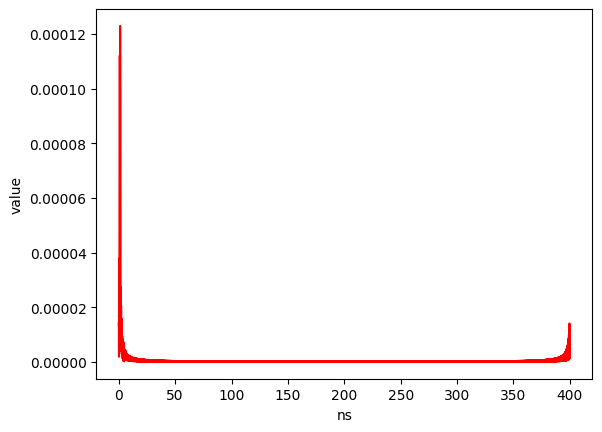

In [111]:
plt.plot(time*1e9, abs(ifft(s11.to_numpy(), n=N_fft)),'r')
plt.xlabel('ns')
plt.ylabel('value');

In [112]:
gate_s11 = np.array([[100, 300], [350, 400]])*1e-9 # заполнить промежутками времени, которые необходимо вырезать в нс
gate_s21 = np.array([[], []])

In [113]:
def time_gate_s_param(gate: np.ndarray, s_par: pd.core.series.Series, n=N_fft, time=time):
    s = s_par.to_numpy()
    time_dom_s = pd.Series(ifft(s, n=n))
    for k in range(gate.shape[0]):
        numbers = (time >= gate[k, 0]) & (time <= gate[k, 1])
        time_dom_s.loc[numbers] = 0
    s_new = fft(time_dom_s.to_numpy())
    return pd.Series(s_new)

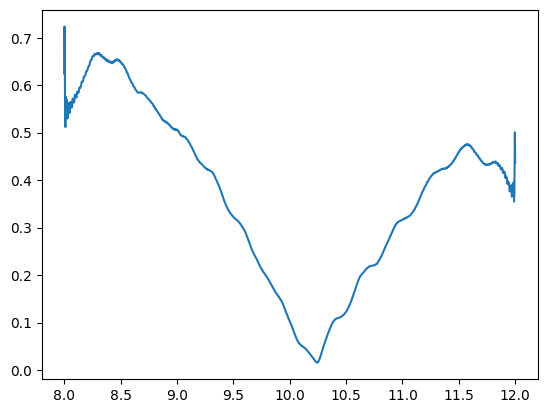

In [115]:
s11 = time_gate_s_param(gate=gate_s11, s_par=s11)
plt.plot(frequency*1e-9, s11.apply(abs)[0:len(frequency)]);

### Сalibration